# Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# print('Importing libraries and defining some helper functions...')
# %load_ext google.colab.data_table
# from google.colab import files
# from google.colab import output

# # print('Installing dependencies...')
# !apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
# !pip install -q pyfluidsynth
# !pip install -qU magenta

# # Hack to allow python to pick up the newly-installed fluidsynth lib.
# # This is only needed for the hosted Colab environment.
# import ctypes.util
# orig_ctypes_util_find_library = ctypes.util.find_library
# def proxy_find_library(lib):
#   if lib == 'fluidsynth':
#     return 'libfluidsynth.so.1'
#   else:
#     return orig_ctypes_util_find_library(lib)
# ctypes.util.find_library = proxy_find_library

ModuleNotFoundError: No module named 'google.colab'

In [41]:
midi_dataset ='lmd_matched' #@param ['lmd_matched','clean_midi']

bars = '2bar' #@param ["2bar",'16bar']

In [42]:
temperature = 1

import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import tables
import json

save_path = Path(os.path.join('outputs',midi_dataset,bars))

save_path.mkdir(parents=True, exist_ok=True)

read_path = save_path

In [43]:
BASE_DIR = "gs://download.magenta.tensorflow.org/models/music_vae/colab2"

import magenta.music as mm
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
import tensorflow.compat.v1 as tf

import note_seq
from note_seq.protobuf import music_pb2

tf.disable_v2_behavior()

# Necessary until pyfluidsynth is updated (>1.2.5).
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [44]:
def play(note_sequence):
  mm.play_sequence(note_sequence, synth=mm.fluidsynth)

def interpolate(model, start_seq, end_seq, num_steps, max_length=32,
                assert_same_length=True, temperature=0.5,
                individual_duration=4.0):
  """Interpolates between a start and end sequence."""
  note_sequences = model.interpolate(
      start_seq, end_seq,num_steps=num_steps, length=max_length,
      temperature=temperature,
      assert_same_length=assert_same_length)

  print('Start Seq Reconstruction')
  play(note_sequences[0])
  print('End Seq Reconstruction')
  play(note_sequences[-1])
  print('Mean Sequence')
  play(note_sequences[num_steps // 2])
  print('Start -> End Interpolation')
  interp_seq = mm.sequences_lib.concatenate_sequences(
      note_sequences, [individual_duration] * len(note_sequences))
  play(interp_seq)
  mm.plot_sequence(interp_seq)
  return interp_seq if num_steps > 3 else note_sequences[num_steps // 2]

def download(note_sequence, filename):
  mm.sequence_proto_to_midi_file(note_sequence, filename)
  files.download(filename)

# !pip install --upgrade music21
from music21 import *

def get_midi_files(artist,i,j):
    midi_data = [
    tf.io.gfile.GFile(fn, 'rb').read()
    for fn in tf.io.gfile.glob(os.path.join(path , artist , '*.mid'))[i:j] ]
    return midi_data

base_path = Path(".")
path = os.path.join(base_path, 'LMD')

# Local path constants
DATA_PATH = os.path.join(path,'data')
RESULTS_PATH = os.path.join(path,'results')
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(h5):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

fs = features.jSymbolic.extractorsById
feats = []

for k in fs:

    for i in range(len(fs[k])):

      if fs[k][i] is not None:

        n = fs[k][i].__name__

        if fs[k][i] not in features.jSymbolic.featureExtractors:

           n += ' (not implemented)'

        feats.append([k,i,n])

feats = pd.DataFrame(feats,columns=['type','number','name'])
feats = feats[~feats['type'].isin(['I','T'])]
feats = feats[~feats['name'].str.contains('(not implemented)')]
feats= feats.reset_index(drop=True)

def extract_jsymb(stream):
    names = []
    values = []
    descriptions = []
    dimensions = []
    types = []
    numbers = []
    names = []
    labels = []
    feature_ids = []

    counter = 0

    for i in range(feats.shape[0]):
        feature_type = feats['type'].iloc[i]
        feature_number = feats['number'].iloc[i]
        feature_extractor = features.jSymbolic.getExtractorByTypeAndNumber(feature_type, feature_number)
        fe = feature_extractor(stream)
        name = feature_extractor.__name__
        extract = fe.extract()
        description = extract.name
        vector_dimensions = extract.dimensions        
        vector = extract.vector

        labels = labels + fe.getAttributeLabels()

        counter = 0
        for dim in range(vector_dimensions):

            counter += 1
            feature_ids.append(feature_type + str(feature_number) + '_' + str(counter) + '/' + str(vector_dimensions))
            types.append(feature_type)
            numbers.append(feature_number)
            names.append(name)
            dimensions.append(vector_dimensions)
            descriptions.append(description)
            values.append(vector[dim])

    temp = pd.DataFrame(values).T
    temp.columns = feature_ids
    return temp, feature_ids

# Grab a Million Song Dataset ID from the scores dictionary
with open(SCORE_FILE) as f:
    scores = json.load(f)

def random_msd_id():
    # Grab a Million Song Dataset ID from the scores dictionary
    chosen_song = np.random.choice(len(list(scores.keys())))
    msd_id = list(scores.keys())[chosen_song]
    return msd_id

def match_midi(msd_id):
#list matches
    df = pd.DataFrame.from_dict(scores[msd_id],orient='index').reset_index()
    df.columns = ['midi_file','confidence_score']
#    display(df)

    #select best match midi
    best_match_score = df.confidence_score.max()
    midi_md5 = df.midi_file[df.confidence_score.argmax()]

    midi_path = get_midi_path(msd_id, midi_md5, 'matched')
    return msd_id, midi_md5, best_match_score, midi_path

def msd_fields(msd_id):
    with tables.open_file(msd_id_to_h5(msd_id)) as h5:
        temp = pd.DataFrame([
                            ['msd_id',msd_id]
                            ,['artist_terms',list([b.decode() for b in h5.root.metadata.artist_terms])]
                            ,['artist_terms_freq',list(h5.root.metadata.artist_terms_freq)]
                            ,['artist_terms_weight',list(h5.root.metadata.artist_terms_weight)]
                            ,['artist_mbtags',list([b.decode() for b in h5.root.musicbrainz.artist_mbtags])]
                            ,['similar_artists',list([b.decode() for b in h5.root.metadata.similar_artists])]
                            ])
        temp = temp.append(pd.DataFrame([h5.root.metadata.songs.colnames,h5.root.metadata.songs.cols[0]])
                                        .T,ignore_index=True)
        

        temp = temp.append(pd.DataFrame([h5.root.analysis.songs.colnames,h5.root.analysis.songs.cols[0]])
                                        .T,ignore_index=True)
        
    temp = temp.set_index(0)
#    display(temp)
    temp = temp.T
    return temp

if bars == '16bar':
    n_bars = 16
    model_config = configs.CONFIG_MAP['hierdec-mel_16bar']
    model = TrainedModel(model_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_16bar_hierdec.ckpt')

else:
    n_bars = 2
    model_config = configs.CONFIG_MAP['cat-mel_2bar_big']
    model = TrainedModel(model_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_2bar_big.ckpt')

def msd_id2fields(msd_id):
    df = msd_fields(msd_id)
    df = df.set_index(['msd_id'])
#    display(df)
    df.to_csv(os.path.join(save_path,'msd_fields.csv'), mode='a', index=True, header=False)
      
def midi2mels(midi_file):
    midi_data = [
    tf.io.gfile.GFile(fn, 'rb').read()
    for fn in sorted(tf.io.gfile.glob(midi_file))]

    try:
        input = mm.midi_to_sequence_proto(midi_data[0])
        # print(f'\nSuccessfully converted midi track')
 
        mels = []

        mels.extend(
            model_config.data_converter.from_tensors(
            model_config.data_converter.to_tensors(input)[1]))
        # print(f'\nSuccessfully extracted melodies')
        
    except:
        # print(f'\nFailure while reading reading midi track\nor extracting melodies')
        failures +=5

    return mels

def initialize(df,filename,col_names,index_label=['msd_id','midi_md5','melody_number']):
    try:
        df=pd.read_csv(os.path.join(save_path,filename))
        print(df.shape)
        print(f"\nFile already exist in directory {save_path}:\n{filename}\nWill append to file.\n")
        

    except:
        print(f"\nFile not found:\n{filename}\n\n in directory:\n{save_path}\nWriting header.\n")
        df = pd.DataFrame(columns=col_names)
        df.to_csv(os.path.join(save_path,filename), index=True, index_label = index_label, mode = 'w')

/Users/johannes/opt/anaconda3/envs/magenta/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]

INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]



/Users/johannes/opt/anaconda3/envs/magenta/lib/python3.7/site-packages/magenta/models/music_vae/lstm_utils.py:99: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/Users/johannes/opt/anaconda3/envs/magenta/lib/python3.7/site-packages/magenta/contrib/rnn.py:750: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.

/Users/johannes/opt/anaconda3/envs/magenta/lib/python3.7/site-packages/magenta/contrib/rnn.py:753: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.

/Users/johannes/opt/anaconda3/envs/magenta/lib/python3.7/site-packages/magenta/models/music_vae/base_model.py:199: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

/Users/johannes/opt/ana

INFO:tensorflow:Restoring parameters from gs://download.magenta.tensorflow.org/models/music_vae/colab2/checkpoints/mel_2bar_big.ckpt


In [45]:
#run a check, also needed the first time to extract the names of the jsymb features
z = np.random.normal(0,1,size=(1,512))
nss = model.decode(z,length = 16*n_bars,temperature=temperature)

for ns in nss[:1]:
#    mm.plot_sequence(ns)
#    play(ns)
    mm.sequence_proto_to_midi_file(ns, 'temp.mid')
    stream = converter.parse('temp.mid')
    extracted = extract_jsymb(stream)
    feature_ids = extracted[1]
extracted[0]

M1_1/128  M1_2/128  M1_3/128  M1_4/128  M1_5/128  M1_6/128  M1_7/128  \
0       0.5       0.0       0.0       0.0       0.0       0.0       0.0   

   M1_8/128  M1_9/128  M1_10/128  ...  R24_1/1  R25_1/1  R30_1/1  R31_1/2  \
0       0.0       0.0        0.0  ...      1.0      0.5    120.0      4.0   

   R31_2/2  R32_1/1  R33_1/1  R34_1/1  R35_1/1  R36_1/1  
0      4.0      0.0      0.0      0.0      0.0      4.0  

[1 rows x 332 columns]

In [46]:
if bars == '16bar':
    music_neurons = [470,
 507,
 282,
 14,
 191,
 289,
 33,
 163,
 30,
 394,
 133,
 477,
 16,
 118,
 140,
 297,
 451,
 398,
 123,
 101,
 168,
 355,
 496,
 82,
 421,
 280,
 363,
 272,
 423,
 502,
 251,
 335,
 460,
 165,
 119,
 203,
 95,
 356,
 210,
 13,
 484,
 18,
 382,
 235,
 81,
 249,
 68,
 147,
 310,
 412,
 390,
 275,
 369,
 97,
 405,
 403,
 248,
 263,
 208,
 281,
 430,
 155,
 300,
 154,
 336,
 185,
 3,
 236,
 400,
 314,
 246,
 107,
 486,
 69,
 504,
 474,
 58]
    noise_neurons = list(set(range(512)) - set(music_neurons))
    neuron_sets = [[470],
 [289],
 [140],
 [451],
 [297],
 [251],
 [423],
 [95],
 [484],
 [68],
 [97],
 [412],
 [155],
 [236],
 [107],
 [474],
 [91],
 [453],
 [339],
 [150],
 [337],
      noise_neurons]
if bars == '2bar':
    music_neurons = [182,
     12,
     471,
     371,
     226,
     377,
     167,
     245,
     294,
     216,
     24,
     73,
     483,
     262,
     41,
     345,
     476,
     473,
     266,
     62,
     370,
     298,
     458,
     36,
     211,
     482,
     283,
     270,
     384,
     175,
     177,
     199,
     187,
     135,
     480,
     387,
     367]
    noise_neurons = list(set(range(0, 512)) - set(music_neurons))
    neuron_sets = [list(range(512)), music_neurons, [182, 12], [182], [12], noise_neurons, []]
list(range(len(neuron_sets)))

[0, 1, 2, 3, 4, 5, 6]

In [47]:
index_label = ['msd_id','midi_md5','melody_number']

jsymb = pd.DataFrame()
initialize(jsymb,'extracted_jsymb.csv',feature_ids,index_label=index_label)

encodings = pd.DataFrame()
initialize(encodings,'latent_encodings.csv',list(range(512)),index_label=index_label)

encoding_sigmas = pd.DataFrame()
initialize(encoding_sigmas,'encoding_sigmas.csv',list(range(512)),index_label=index_label)

encoding_samples = pd.DataFrame()
initialize(encoding_sigmas,'encoding_samples.csv',list(range(512)),index_label=index_label)

accuracies = pd.DataFrame()
initialize(accuracies,'accuracies.csv',list(range(len(neuron_sets))),index_label=index_label)

IoUs = pd.DataFrame()
initialize(accuracies,'IoUs.csv',list(range(len(neuron_sets))),index_label=index_label)

compare_accuracies = pd.DataFrame()
initialize(compare_accuracies,'compare_accuracies.csv',['accuracy'],index_label=index_label)

compare_IoUs = pd.DataFrame()
initialize(compare_IoUs,'compare_IoUs.csv',['IoU'],index_label=index_label)

import random

jsymb = pd.read_csv(os.path.join(read_path,'extracted_jsymb.csv'))
encodings = pd.read_csv(os.path.join(read_path,'latent_encodings.csv'))
sigmas = pd.read_csv(os.path.join(read_path,'encoding_sigmas.csv'))
accuracies = pd.read_csv(os.path.join(read_path,'accuracies.csv'))
IoUs = pd.read_csv(os.path.join(read_path,'IoUs.csv'))

print(jsymb.shape,encodings.shape,sigmas.shape)

all_song_ids = set(scores.keys())
successful_encodings_song_ids = set(encodings.msd_id)
successful_jsymb_song_ids = set(jsymb.msd_id)
intersection_song_ids = successful_encodings_song_ids.intersection(successful_jsymb_song_ids)

remaining_song_ids = list(set(all_song_ids) - set(successful_encodings_song_ids))
random.shuffle(remaining_song_ids)

successful_sigmas_song_ids = set(sigmas.msd_id)

print(f'\n\n{len(all_song_ids)} tracks total.\
\n{len(successful_encodings_song_ids)} tracks with latent vectors successfully encoded for at least one melody.\
\n{len(successful_jsymb_song_ids)} track with symbolic features extracted for at least one melody.\
\n\n{len(intersection_song_ids)} tracks with both.\
\n\n{len(remaining_song_ids)} tracks remaining.\
\n{len(successful_sigmas_song_ids)} tracks with latent distributions successfully encoded for at least one melody.'
)


(55332, 335)

File already exist in directory outputs/lmd_matched/2bar:
extracted_jsymb.csv
Will append to file.

(66118, 515)

File already exist in directory outputs/lmd_matched/2bar:
latent_encodings.csv
Will append to file.

(16692, 515)

File already exist in directory outputs/lmd_matched/2bar:
encoding_sigmas.csv
Will append to file.

(6164, 515)

File already exist in directory outputs/lmd_matched/2bar:
encoding_samples.csv
Will append to file.

(6164, 10)

File already exist in directory outputs/lmd_matched/2bar:
accuracies.csv
Will append to file.

(6164, 10)

File already exist in directory outputs/lmd_matched/2bar:
IoUs.csv
Will append to file.

(700, 4)

File already exist in directory outputs/lmd_matched/2bar:
compare_accuracies.csv
Will append to file.

(700, 4)

File already exist in directory outputs/lmd_matched/2bar:
compare_IoUs.csv
Will append to file.

(55332, 335) (66118, 515) (16692, 515)


31034 tracks total.
11665 tracks with latent vectors successfully encoded 

In [56]:
failures = 0

for i, msd_id in tqdm(enumerate(remaining_song_ids[:200])): #30 track in one hour for 16 bar
    n_attempted_melodies = 5 * i
    # print(f'\n\n{failures} failures out of {n_attempted_melodies} attempted melodies.\n\n')
    try:        
        match_results = match_midi(msd_id)
#        msd_id2fields(msd_id)
        msd_id, midi_md5, match_score, midi_file = match_results
        mels = midi2mels(midi_file)
        # print(len(mels),' melodies')

    except:
        # print('Failed to extract melodies')
        failures +=5
        continue

    for mel_num, mel in enumerate(mels[:]):
        # print(f'\nMelody {mel_num}')
        
        try:
            sample, mu, sigma = model.encode([mel])
            df = pd.DataFrame(np.squeeze(mu).tolist()).T
            df.insert(0,'melody_number',mel_num)
            df.insert(0,'midi_md5',midi_md5)
            df.insert(0,'msd_id',msd_id)
            df = df.set_index(['msd_id','midi_md5','melody_number'])
#            display(df)
            df.to_csv(os.path.join(save_path,'latent_encodings.csv'), mode='a', header=False, index=True)#, index_label = ['msd_id','midi_md5','melody_number'])
            
            df = pd.DataFrame(np.squeeze(sigma).tolist()).T
            df.insert(0,'melody_number',mel_num)
            df.insert(0,'midi_md5',midi_md5)
            df.insert(0,'msd_id',msd_id)
            df = df.set_index(['msd_id','midi_md5','melody_number'])
#            display(df)
            df.to_csv(os.path.join(save_path,'encoding_sigmas.csv'), mode='a', header=False, index=True)#, index_label = ['msd_id','midi_md5','melody_number'])

            df = pd.DataFrame(np.squeeze(sample).tolist()).T
            df.insert(0,'melody_number',mel_num)
            df.insert(0,'midi_md5',midi_md5)
            df.insert(0,'msd_id',msd_id)
            df = df.set_index(['msd_id','midi_md5','melody_number'])
#            display(df)
            df.to_csv(os.path.join(save_path,'encoding_samples.csv'), mode='a', header=False, index=True)#, index_label = ['msd_id','midi_md5','melody_number'])

            # print('Successful encoding')

            accuracies = []
            IoUs = []
            
            input_array = np.argmax(model_config.data_converter.to_tensors(mel).outputs[0], axis=1)
            
            for i, neurons in enumerate(neuron_sets):
                sample_pruned = sample.copy()
                sample_pruned[0, neurons] = 0
                # out_ns = model.decode(sample_pruned, length=32, temperature=1)[0]
                # mm.plot_sequence(out_ns)
                # play(rns)
                tensors = model.decode_to_tensors(sample_pruned, length=16 * n_bars, temperature=1)[0]
                
                events = []
                for tensor in tensors:
                    events.append(np.argmax(tensor))
                output_array = np.array(events)
                accuracy = ((output_array - input_array) == 0).mean()
                IoU = (((output_array - input_array) == 0) * ((input_array + output_array) > 0)).sum() / (((input_array + output_array) > 0).sum())
            
                # df[str(neuron)] = accuracy
                accuracies.append(accuracy)
                IoUs.append(IoU)

            df = pd.DataFrame(accuracies).T
            # df.columns = neurons
            df.insert(0,'melody_number',mel_num)
            df.insert(0,'midi_md5',midi_md5)
            df.insert(0,'msd_id',msd_id)
            df = df.set_index(['msd_id','midi_md5','melody_number'])
            df.to_csv(os.path.join(save_path,'accuracies.csv'), mode='a', header=False, index=True)#, index_label = ['msd_id','midi_md5','melody_number'])

            df = pd.DataFrame(IoUs).T
            # df.columns = neurons
            df.insert(0,'melody_number',mel_num)
            df.insert(0,'midi_md5',midi_md5)
            df.insert(0,'msd_id',msd_id)
            df = df.set_index(['msd_id','midi_md5','melody_number'])
            df.to_csv(os.path.join(save_path,'IoUs.csv'), mode='a', header=False, index=True)#, index_label = ['msd_id','midi_md5','melody_number'])

            compare_accuracies = []
            compare_IoUs = []


            tensors_all_latents = model.decode_to_tensors(sample, length=16 * n_bars, temperature=1)[0]
            events = []
            for tensor in tensors_all_latents:
                events.append(np.argmax(tensor))
            array_all_latents = np.array(events)

            sample_pruned = sample.copy()
            sample_pruned[0, noise_neurons] = 0
            tensors_no_irrelevant = model.decode_to_tensors(sample_pruned, length=16 * n_bars, temperature=1)[0]

            events = []
            for tensor in tensors_no_irrelevant:
                events.append(np.argmax(tensor))
            array_no_irrelevant = np.array(events)
            compare_accuracy = ((array_no_irrelevant - array_all_latents) == 0).mean()
            compare_IoU = (((array_no_irrelevant - array_all_latents) == 0) \
                             * ((array_no_irrelevant + array_all_latents) > 0)).sum() / (((array_no_irrelevant + array_all_latents) > 0).sum())

            compare_accuracies.append(compare_accuracy)
            compare_IoUs.append(compare_IoU)

            
            df = pd.DataFrame(compare_accuracies).T
            # df.columns = neurons
            df.insert(0,'melody_number',mel_num)
            df.insert(0,'midi_md5',midi_md5)
            df.insert(0,'msd_id',msd_id)
            df = df.set_index(['msd_id','midi_md5','melody_number'])
            df.to_csv(os.path.join(save_path,'compare_accuracies.csv'), mode='a', header=False, index=True)#, index_label = ['msd_id','midi_md5','melody_number'])

            df = pd.DataFrame(compare_IoUs).T
            # df.columns = neurons
            df.insert(0,'melody_number',mel_num)
            df.insert(0,'midi_md5',midi_md5)
            df.insert(0,'msd_id',msd_id)
            df = df.set_index(['msd_id','midi_md5','melody_number'])
            df.to_csv(os.path.join(save_path,'compare_IoUs.csv'), mode='a', header=False, index=True)#, index_label = ['msd_id','midi_md5','melody_number'])

        except:
            # print('Failure during encoding')
            failures +=1
            continue

        try:
            mm.note_sequence_to_midi_file(mel,'temp.mid')
            stream = converter.parse('temp.mid')
            df = extract_jsymb(stream)[0]
            df.insert(0,'melody_number',mel_num)
            df.insert(0,'midi_md5',midi_md5)
            df.insert(0,'msd_id',msd_id)
            df = df.set_index(['msd_id','midi_md5','melody_number'])
#            display(df)
            df.to_csv(os.path.join(save_path,'extracted_jsymb.csv'), mode='a', header=False, index=True)#, index_label = ['msd_id','midi_md5','melody_number'])
            # print('Successful extraction of symbolic features')
        except:
            # print('Failure while extracting symbolic features')
            failures +=1
    # output.clear()     

2it [00:26, 11.03s/it]/Users/johannes/opt/anaconda3/envs/magenta/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning:

Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.

200it [1:54:09, 34.25s/it]


# Ablation results

In [11]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pd.options.plotting.backend = 'plotly'

In [48]:
compare_IoUs = pd.read_csv(os.path.join(read_path,'compare_IoUs.csv')).set_index(['msd_id','midi_md5','melody_number'])
compare_IoUs.plot.hist(marginal='box').show()
compare_IoUs.describe()#points='all')#bar(height=400)

IoU
count  700.000000
mean     0.692143
std      0.220564
min      0.000000
25%      0.543706
50%      0.714286
75%      0.875000
max      1.000000

In [49]:
compare_accuracies = pd.read_csv(os.path.join(read_path,'compare_accuracies.csv')).set_index(['msd_id','midi_md5','melody_number'])
compare_accuracies.plot.hist(marginal='box').show()#.mean().plot.bar(height=400)
compare_accuracies.describe()

accuracy
count  700.000000
mean     0.852143
std      0.157907
min      0.187500
25%      0.812500
50%      0.906250
75%      0.968750
max      1.000000

In [50]:
accuracies = pd.read_csv(os.path.join(read_path,'accuracies.csv')).set_index(['msd_id','midi_md5','melody_number'])
accuracies.mean().plot.bar(height=400)

In [51]:
accuracies.melt().plot.box(x='variable', y='value', height=700, points='all')

In [52]:
IoUs = pd.read_csv(os.path.join(read_path,'IoUs.csv')).set_index(['msd_id','midi_md5','melody_number'])
IoUs.mean().plot.bar(height=400)

In [53]:
IoUs.melt().plot.box(x='variable', y='value', height=700)#, points='all')

In [54]:
IoUs.columns = list(map(str, IoUs.columns))
res = IoUs.melt()
res

variable     value
0            0  0.000000
1            0  0.038462
2            0  0.000000
3            0  0.000000
4            0  0.000000
...        ...       ...
43143        6  0.727273
43144        6  0.727273
43145        6  0.500000
43146        6  0.900000
43147        6  0.800000

[43148 rows x 2 columns]

In [55]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
%%R

library(tidyverse)
# library(lvplot)
library(patchwork)
library(plotly)
library(viridis)
library(here)

theme_set(theme_bw())

neuron_label = 'Neurons sorted by relevance'
feature_label = 'Music features'

rel_size = 2
width = 16
height = 8

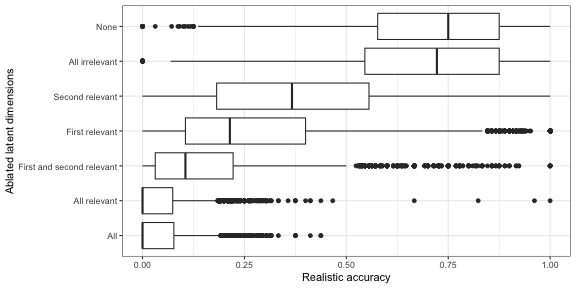

In [57]:
%%R -i res,n_bars -w 8 -h 4 -u in

p = res %>%
    as_tibble() %>%
    # filter(variable != 0) %>%
    ggplot(aes(variable, value)) +
    geom_boxplot() +
    scale_x_discrete(labels = c('All', 'All relevant', 'First and second relevant', 'First relevant', 'Second relevant', 'All irrelevant', 'None')) +
#     # scale_y_continuous(breaks = c(0, 20, 40, 60, 80, 100)) +
    coord_flip() +
    labs(x='Ablated latent dimensions',
         y='Realistic accuracy')
ggsave(here('figures', paste(n_bars, 'ablation.pdf', sep='_')), width=8, height=4)
p 

# Check output

In [ ]:
midi_dataset ='lmd_matched' #@param ['lmd_matched','clean_midi']

bars = '2bar' #@param ["2bar",'16bar']

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
from pathlib import Path
import pandas as pd
save_path = Path(os.path.join('/content/drive/MyDrive/ml/music/outputs',midi_dataset,bars))

save_path.mkdir(parents=True, exist_ok=True)

read_path = save_path
fields = pd.read_csv(os.path.join(read_path,'msd_fields.csv'))
fields.shape

Mounted at /content/drive


(16209, 57)

In [ ]:

jsymb = pd.read_csv(os.path.join(read_path,'extracted_jsymb.csv'))
encodings = pd.read_csv(os.path.join(read_path,'latent_encodings.csv'))
print(jsymb.shape,encodings.shape,fields.shape)

(40110, 335) (47680, 515) (16209, 57)


In [ ]:
display(jsymb)
display(encodings)
display(fields)